# Cookbook for CREST files preparation
Step by step manual for CREST input files preparation.

## 1 Basic Folder
This folder contains the raster files that represent the geographic information of the basin and a text file that defines the average height difference. 

Files in the basic folder are: 
- /basic
    - dem.tif
    - fdr.tif
    - fac.tif
    - stream.tif
    - refMask.tif
    - slope.def

### 1.2 Environment

In [ ]:
!pip install pysheds geopandas shapely matplotlib

### 1.2 Download DEM
The DEM will be downloaded from hydrosheds, run the following cell.

(backup link:https://data.hydrosheds.org/file/hydrosheds-v1-dem/hyd_eu_dem_15s.zip)

In [8]:
import requests
import zipfile
import os

# URL of the file to download
url = "https://data.hydrosheds.org/file/hydrosheds-v1-dem/hyd_eu_dem_15s.zip"

# Directory path
directory = "./demo_project/"

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)

# Download the file
response = requests.get(url)
filename = directory + "hyd_eu_dem_15s.zip"

with open(filename, "wb") as file:
    file.write(response.content)

# Unzip the file
with zipfile.ZipFile(filename, "r") as zip_ref:
    zip_ref.extractall(directory)

# Find the .tif file
input_dem_file = None
for file in os.listdir(directory):
    if file.endswith(".tif"):
        input_dem_file = os.path.join(directory, file)
        break

# Delete the .zip file
os.remove(filename)

# Print the input file path
print("Input file path:", input_dem_file)


Input file path: ./demo_project/hyd_eu_dem_15s.tif


### 1.3 Outlet and basin extent
Two parameters are needed, the coordinates of:
1. Approximate basin geoextent
2. outlet point

In [17]:
crop_extent = (39.23, 21.5, 42.00, 19.15)  # Specify the geographic extent in (left, top, right, bottom) format
x, y = 40.46448, 20.42804 # Specify the location of the center point in (longitude, latitude) format

Create outlet shapefile

In [18]:
import geopandas as gpd
from shapely.geometry import Point

# Create a GeoDataFrame with the point geometry
geometry = [Point(x, y)]
crs = "EPSG:4326"  # Coordinate reference system, WGS84 (standard for latitude and longitude)
gdf = gpd.GeoDataFrame(geometry=geometry, crs=crs)

# Update the field name
gdf["Name"] = "Wadi_418"

# Output directory path
output_directory = "./demo_project/outlet_obs/"

# Create the directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Save the GeoDataFrame as a shapefile
output_file = output_directory + "Wadi_418.shp"
gdf.to_file(output_file)

# Print the output file path
print("Shapefile saved to:", output_file)


Shapefile saved to: ./demo_project/outlet_obs/Wadi_418.shp


### 1.4 DEM preprocess
Crop the DEM based on user provided geoextent: crop_extent

### 1.5 FDR FAC generation


In [19]:
import rasterio
from rasterio.enums import Resampling
from rasterio.transform import from_origin

# Import plot modules
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
import numpy as np

input_file = input_dem_file # unzipped dem file, speficy it if manually downloaded
output_file = './demo_project/hyd_eu_dem_15s_setnan_cropped.tif'
desired_nodata = -32768

# Read the raster file
with rasterio.open(input_file) as src:
    # Get the geospatial information
    transform = src.transform
    crs = src.crs
    nodata = src.nodata

    # Determine the window to crop
    left, top, right, bottom = crop_extent
    row_start, col_start = src.index(left, top)
    row_stop, col_stop = src.index(right, bottom)
    window = rasterio.windows.Window(col_start, row_start, col_stop - col_start, row_stop - row_start)

    # Calculate the new transform for the cropped area
    crop_transform = from_origin(transform[0] * window.col_off + transform[2], transform[4] * window.row_off + transform[5],
                                 transform[0], -transform[4])  # Note the negative sign

    # Read the cropped data
    data = src.read(1, window=window)

    # Modify the nodata value
    data[data == nodata] = desired_nodata

    # Update the metadata with the new nodata value and transform
    profile = src.profile
    profile.update(nodata=desired_nodata, transform=crop_transform, height=data.shape[0], width=data.shape[1])

    # Write the cropped and modified data to a new file
    with rasterio.open(output_file, 'w', **profile) as dst:
        dst.write(data, 1)

In [20]:
# Read DEM raster
# ----------------------------
grid = Grid.from_raster(output_file)
dem = grid.read_raster(output_file)

# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)
# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

# Option: Export the flow accumulation to a raster file, check the outlet location in QGIS/ArGIS
# --------------------------
#output_file = '/Users/qyang/Downloads/data/CREST/Demo_case/hyd_na_dem_15s/cropped_acc.tif'
#grid.to_raster(acc, output_file)

### 1.6 Basin generation
Generate a basin mask based on the outlet point and the FDR


In [21]:
# Delineate the catchment with outlet
# --------------------------
# Reset the view
grid.viewfinder = fdir.viewfinder

# Option 1: Use the Specified outlet point with longitude and latitude
x, y = x, y # Wadi 418 have set up before
# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))
# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, xytype='coordinate')

# Option 2: Specify outlet point with row and column index on accumulation file
#col, row = _,_
# Delineate the catchment
#catch = grid.catchment(x=col, y=row, fdir=fdir, xytype='index')

# Plot the result
grid.clip_to(catch)
catch_view = grid.view(catch)

Text(0.5, 1.0, 'Delineated Catchment')

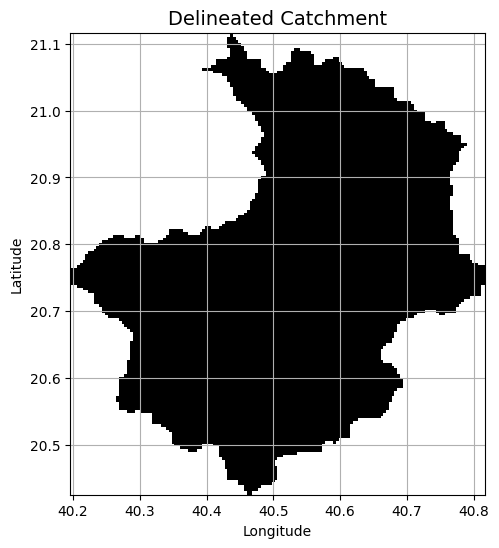

In [22]:
# Plot the catchment shape for inspection
# --------------------------
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(catch_view, catch_view, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)

### 1.6 Basic file clip and export

In [23]:
# clip dem, fdir, acc to catchment
# --------------------------
dem_basic = grid.view(dem, nodata=np.nan)
fdr_basic = grid.view(fdir, nodata=np.nan)
fac_basic = grid.view(acc, nodata=np.nan)

# get stream with threshold 96
# --------------------------
stream_basic = np.where(fac_basic >= 96, 1, np.nan)

# get refMask (pixel id mask)
# --------------------------
# Count the number of non-NaN pixels in the catchment
n = np.count_nonzero(~np.isnan(dem_basic))
# Create a new raster with the same shape as dem_basic
refMask = np.zeros_like(dem_basic)
# Assign values from 1 to n to non-NaN pixels
refMask[~np.isnan(dem_basic)] = range(1, n + 1)
refMask = np.where(refMask >= 1, refMask, np.nan)



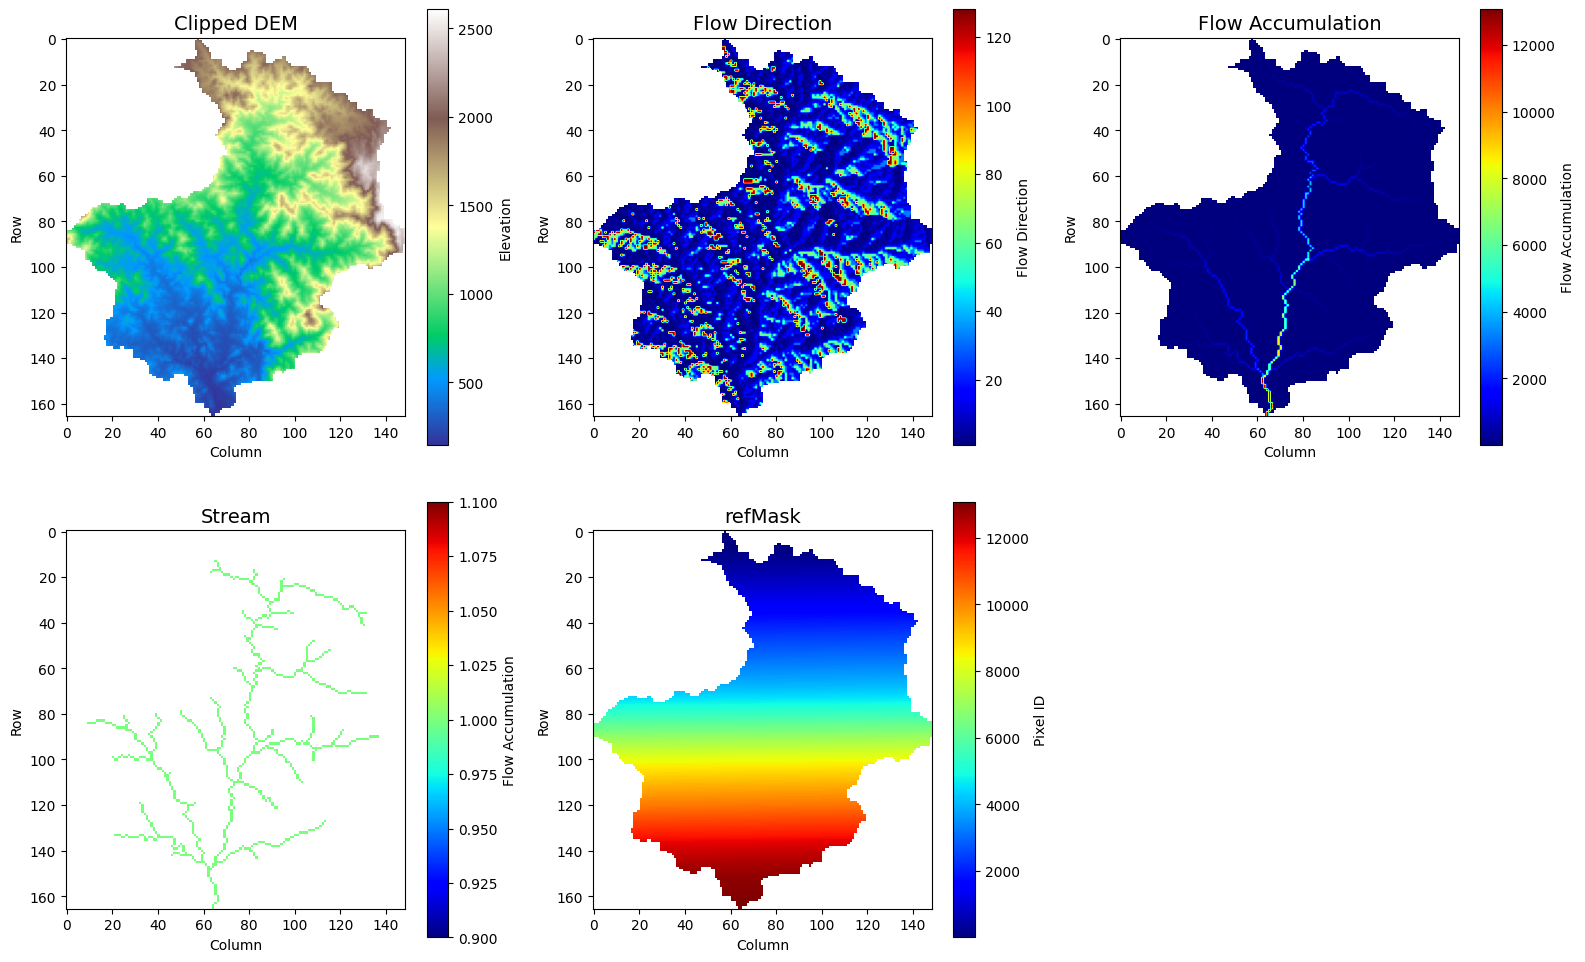

In [27]:
#review the clip results
# Create the figure and axes
fig, axs = plt.subplots(2, 3, figsize=(16, 10))
fig.patch.set_alpha(0)

# Plot dem_basic
im1 = axs[0, 0].imshow(dem_basic, cmap='terrain')
axs[0, 0].set_title('Clipped DEM', size=14)
axs[0, 0].set_xlabel('Column')
axs[0, 0].set_ylabel('Row')
fig.colorbar(im1, ax=axs[0, 0], label='Elevation')

# Plot fdr_basic
im2 = axs[0, 1].imshow(fdr_basic, cmap='jet')
axs[0, 1].set_title('Flow Direction', size=14)
axs[0, 1].set_xlabel('Column')
axs[0, 1].set_ylabel('Row')
fig.colorbar(im2, ax=axs[0, 1], label='Flow Direction')

# Plot fac_basic
im3 = axs[0, 2].imshow(fac_basic, cmap='jet')
axs[0, 2].set_title('Flow Accumulation', size=14)
axs[0, 2].set_xlabel('Column')
axs[0, 2].set_ylabel('Row')
fig.colorbar(im3, ax=axs[0, 2], label='Flow Accumulation')

# Plot stream_basic
im4 = axs[1, 0].imshow(stream_basic, cmap='jet',interpolation = 'nearest')
axs[1, 0].set_title('Stream', size=14)
axs[1, 0].set_xlabel('Column')
axs[1, 0].set_ylabel('Row')
fig.colorbar(im4, ax=axs[1, 0], label='Flow Accumulation')

# Plot refMask
im5 = axs[1, 1].imshow(refMask, cmap='jet')
axs[1, 1].set_title('refMask', size=14)
axs[1, 1].set_xlabel('Column')
axs[1, 1].set_ylabel('Row')
fig.colorbar(im5, ax=axs[1, 1], label='Pixel ID')

# Remove empty subplot
fig.delaxes(axs[1, 2])

# Adjust the layout
plt.tight_layout()

# Show the figure
plt.show()


In [28]:
# Export the basic rasters to GeoTiff
# --------------------------
import os
output_folder = './demo_project/basic' # User specified folder,basic is what we recommend
output_files = ['dem.tif', 'fdr.tif', 'fac.tif']
rasters = [dem_basic, fdr_basic, fac_basic]

for file, raster in zip(output_files, rasters):
    output_path = os.path.join(output_folder, file)
    grid.to_raster(raster, output_path)

# Read the fac.tif file
with rasterio.open(output_folder+'/dem.tif') as src:
    # Read the data and metadata
    fac_data = src.read(1)
    profile = src.profile

# Update the profile metadata for the new rasters
profile.update(
    dtype=rasterio.float32,  # Change the data type if necessary
    nodata=np.nan,  # Set the nodata value
    count=1  # Set the number of bands
)

# Write stream.tif
with rasterio.open(output_folder+'/stream.tif', 'w', **profile) as dst:
    dst.write(stream_basic, 1)

# Write refMask.tif
with rasterio.open(output_folder+'/refMask.tif', 'w', **profile) as dst:
    dst.write(refMask, 1)

## 2 Param Folder
This folder contains the raster files of different soil type, land cover and impervious surface. Also contains one .csv file of the coverlib and one .txt file for model landsurface and routing parameters.

Files inside the param folder are:
- /param
<pre>
LCC.tif          IM.tif           CoverLib.csv  parameters.txt
BLD_sd1.tif      CLYPPT_sd1.tif   FC_sd1.tif    KSAT_sd1.tif
BLD_sd2.tif      CLYPPT_sd2.tif   FC_sd2.tif    KSAT_sd2.tif
BLD_sd3.tif      CLYPPT_sd3.tif   FC_sd3.tif    KSAT_sd3.tif
BLD_sd4.tif      CLYPPT_sd4.tif   FC_sd4.tif    KSAT_sd4.tif
BLD_sd5.tif      CLYPPT_sd5.tif   FC_sd5.tif    KSAT_sd5.tif
BLD_sd6.tif      CLYPPT_sd6.tif   FC_sd6.tif    KSAT_sd6.tif
Lambda_sd1.tif   ORCDRC_sd1.tif   SAT_sd1.tif   SNDPPT_sd1.tif   Wwp_sd1.tif
Lambda_sd2.tif   ORCDRC_sd2.tif   SAT_sd2.tif   SNDPPT_sd2.tif   Wwp_sd2.tif
Lambda_sd3.tif   ORCDRC_sd3.tif   SAT_sd3.tif   SNDPPT_sd3.tif   Wwp_sd3.tif
Lambda_sd4.tif   ORCDRC_sd4.tif   SAT_sd4.tif   SNDPPT_sd4.tif   Wwp_sd4.tif
Lambda_sd5.tif   ORCDRC_sd5.tif   SAT_sd5.tif   SNDPPT_sd5.tif   Wwp_sd5.tif
Lambda_sd6.tif   ORCDRC_sd6.tif   SAT_sd6.tif   SNDPPT_sd6.tif   Wwp_sd6.tif
<pre>

- LCC.tif

Land cover and canopy types.

- IM.tif

Impervious area ratio.

- CoverLib.csv

Canopy cover properties parameter.

- parameters.txt

Parameter control file.

- SAT_*.tif

Saturation, refers to the maximum amount of water the soil can hold.

- FC_*.tif

Field capacity, represents the soil moisture content remaining in the soil after gravitational drainage has occurred due to the force of gravity pulling water downwards through the soil profile.

- Wwp_*.tif

Water wilting Point refers to the soil moisture content at which plants begin to experience water stress.

- KSAT_*.tif

The soil saturate hydraulic conductivity.

- SNDPPT_*.tif

SNDPPT represents the percentage of sand particles in the soil (%).

- CLYPPT_*.tif

CLYPPT represents the percentage of clay particles in the soil. (%)

- ORCDRC_*.tif

ORCDRC represents the content of organic carbon in the soil. The unit of ORCDRC is in decagrams per kilogram (dg/kg), also known as parts per thousand (ppt).

- Lambda_*.tif

Lambda is the moisture-tension coefficient, which is used to calculate the relationship between soil moisture and tension. A coefficient.

- BLD_*.tif

BLD represents the bulk density of the soil, which is the mass of dry soil per unit volume. The unit of BLD is in centigrams per cubic centimeter (cg/cm³).

### 2.1 Environment

In [36]:
!pip install soilgrids

  Using cached soilgrids-0.1.4-py3-none-any.whl (12 kB)
  Using cached bmipy-2.0-py3-none-any.whl
  Using cached netCDF4-1.6.4-cp311-cp311-macosx_11_0_arm64.whl (3.2 MB)
  Using cached rioxarray-0.14.1-py3-none-any.whl (53 kB)
  Using cached OWSLib-0.29.2-py2.py3-none-any.whl (221 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 2.5 MB/s eta 0:00:0000:0100:010m
  Using cached cftime-1.6.2-cp311-cp311-macosx_11_0_arm64.whl (207 kB)
  Using cached lxml-4.9.3-cp311-cp311-macosx_11_0_universal2.whl (8.6 MB)
  Using cached mypy_extensions-1.0.0-py3-none-any.whl (4.7 kB)
  Using cached pathspec-0.11.1-py3-none-any.whl (29 kB)


### 2.2 Download soilgrids data

SoilGrids data source: https://soilgrids.org/

Download SoilGrids data based on the geoextent of the basin dem.

In [23]:
import rasterio
from rasterio.warp import transform_bounds
import pyproj
from soilgrids import SoilGrids


# Specify the path to the raster file
file_path = './demo_project/basic/dem.tif'
# Define the target CRS as EPSG:3857
target_crs = pyproj.CRS.from_epsg(3857)
# Read the raster file
with rasterio.open(file_path) as src:
    # Get the bounds in the original CRS
    bounds = src.bounds
    # Transform the bounds to EPSG:3857 CRS
    transformed_bounds = transform_bounds(src.crs, target_crs, *bounds)
# Print the transformed bounds
print(transformed_bounds)

# Specify the download path
out_folder = './demo_project/SoilGrids'
# Create folder to store SoilGrids
os.makedirs(out_folder,exist_ok=True)
# Choose the soil property
ser_ids = ['sand','clay','silt','soc','bdod']
layers = ['0-5cm','5-15cm','15-30cm','30-60cm','60-100cm','100-200cm']
soil_grids = SoilGrids()

west, south, east, north = transformed_bounds[0], transformed_bounds[1], transformed_bounds[2], transformed_bounds[3]
for isid in ser_ids:
    for lyrs in layers:
        tcver_id =isid+'_'+lyrs+'_mean'
        print(tcver_id)               
        data = soil_grids.get_coverage_data(service_id=isid, coverage_id=tcver_id, 
                                        west=west, south=south, east=east, north=north,
                                        crs='urn:ogc:def:crs:EPSG::3857',
                                        output=os.path.join(out_folder, tcver_id+'.tif'))


(4474579.6986779645, 2323446.5607368643, 4543690.549212122, 2405795.2905792375)
sand_0-5cm_mean
sand_5-15cm_mean
sand_15-30cm_mean
sand_30-60cm_mean
sand_60-100cm_mean
sand_100-200cm_mean
clay_0-5cm_mean
clay_5-15cm_mean
clay_15-30cm_mean
clay_30-60cm_mean
clay_60-100cm_mean
clay_100-200cm_mean
silt_0-5cm_mean
silt_5-15cm_mean
silt_15-30cm_mean
silt_30-60cm_mean
silt_60-100cm_mean
silt_100-200cm_mean
soc_0-5cm_mean
soc_5-15cm_mean
soc_15-30cm_mean
soc_30-60cm_mean
soc_60-100cm_mean
soc_100-200cm_mean
bdod_0-5cm_mean
bdod_5-15cm_mean
bdod_15-30cm_mean
bdod_30-60cm_mean
bdod_60-100cm_mean
bdod_100-200cm_mean


### 2.3 Convert SoilGrid data to soil profiles

Convert SoilGrid data to soil profiles and export to param folder.

In [27]:
import os
import rasterio
import numpy as np

def fill_zeros_with_median(arr):
    non_zero_values = arr[arr != 0]
    if non_zero_values.size == 0:
        # All values are zeros, return zero-filled array
        return np.zeros_like(arr)
    else:
        median_val = np.median(non_zero_values)
        arr[arr == 0] = median_val
        return arr

def convert_soilgrid_tifs(input_folder, output_folder):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    # Define the mapping of ser_ids to types
    ser_id_to_type = {
        'sand': 'SNDPPT',
        'clay': 'CLYPPT',
        'silt': 'SLTPPT',
        'soc': 'ORCDRC',
        'bdod': 'BLD'
    }
    # Define the mapping of layers to sd1 to sd6 with their depths
    layer_to_sd = {
        '0-5cm': ('sd1', 0.05),
        '5-15cm': ('sd2', 0.1),
        '15-30cm': ('sd3', 0.15),
        '30-60cm': ('sd4', 0.3),
        '60-100cm': ('sd5', 0.4),
        '100-200cm': ('sd6', 1.0)
    }
    # Loop through each layer to compute soil properties and save them as .tif files
    for layer, (sd_layer, depth) in layer_to_sd.items():
        ser_id_values = {}
        for ser_id, ser_type in ser_id_to_type.items():
            ser_file = os.path.join(input_folder, f'{ser_id}_{layer}_mean.tif')
            if os.path.exists(ser_file):
                with rasterio.open(ser_file) as src:
                    ser_data = src.read(1)
                    ser_data = fill_zeros_with_median(ser_data)
                    ser_id_values[ser_id] = ser_data
            else:
                print(f"Warning: {ser_file} not found for layer {layer}")

        if len(ser_id_values) == len(ser_id_to_type):
            # Convert units to the correct values for S, C, and OM
            S = ser_id_values['sand'] / 1000  # Convert from g/kg to kg/kg
            C = ser_id_values['clay'] / 1000  # Convert from g/kg to kg/kg
            OM = ser_id_values['soc'] / 100  # Convert from dg/kg to kg/kg

            # Compute soil properties using the textriangle_saxton06 function
            Ksat, Lambda, SAT, FC, Wwp = textriangle_saxton06(S, C, OM)

            # Compute BLD (bulk density in kg/m³)
            BLD = ser_id_values['bdod'] / 1000  # Convert from cg/cm³ to kg/m³

            # Compute ORCDC (organic carbon content in kg/kg)
            ORCDC = OM  # Since OM is already in kg/kg

            # Save the computed soil properties as separate .tif files
            save_as_tif(Ksat, os.path.join(output_folder, f'KSAT_{sd_layer}.tif'), ser_file)
            save_as_tif(Lambda, os.path.join(output_folder, f'Lambda_{sd_layer}.tif'), ser_file)
            save_as_tif(SAT, os.path.join(output_folder, f'SAT_{sd_layer}.tif'), ser_file)
            save_as_tif(FC, os.path.join(output_folder, f'FC_{sd_layer}.tif'), ser_file)
            save_as_tif(Wwp, os.path.join(output_folder, f'Wwp_{sd_layer}.tif'), ser_file)
            save_as_tif(BLD, os.path.join(output_folder, f'BLD_{sd_layer}.tif'), ser_file)
            save_as_tif(ORCDC, os.path.join(output_folder, f'ORCDRC_{sd_layer}.tif'), ser_file)
        else:
            print(f"Warning: Some input files not found for layer {layer}")

def textriangle_saxton06(S, C, OM):
    # Algorithm Description
    # This function converts soil texture to soil properties.
    #
    # Reference
    # K. E. Saxton and W. J. Rawls, (2006) "Soil Water Characteristic Estimates by Texture and Organic Matter for Hydrologic Solutions", Soil Society of America Journal
    # input
    # S: Sandy (%w)
    # C: Clay  (%w) 
    # OM: organic material (%w)
    # output
    # Ksat: saturated conductivity (mm/h) [mm/h]
    # SAT: saturated soil moisture (%v) [θ_S(0kPa)]
    # FC: field capacity (%v) [θ_33-DF (33kPa)]
    # Wwp: wilting point soil moisture (%v) [θ_1500 (1500kPa)]
    indexValid = ~np.isnan(S) & ~np.isnan(C) & ~np.isnan(OM)
    [m, n] = S.shape
    Ksat = np.full((m, n), np.nan)
    FC = np.full((m, n), np.nan)
    Wwp = np.full((m, n), np.nan)
    SAT = np.full((m, n), np.nan)
    Lambda = np.full((m, n), np.nan)
    if np.any(S > 1):
        S[indexValid] = S[indexValid] / 100
    if np.any(C > 1):
        C[indexValid] = C[indexValid] / 100
    if np.any(OM > 1):
        OM[indexValid] = OM[indexValid] / 100
    SC = S[indexValid] * C[indexValid]
    COM = C[indexValid] * OM[indexValid]
    SOM = S[indexValid] * OM[indexValid]
    S = S[indexValid]
    C = C[indexValid]
    OM = OM[indexValid]
    # θ_33t
    theta33t = -0.251 * S + 0.195 * C + 0.011 * OM + 0.006 * SOM - 0.027 * COM + 0.452 * SC + 0.299
    # θ_S-33t
    thetaS33t = 0.278 * S + 0.034 * C + 0.022 * OM - 0.018 * SOM - 0.027 * COM - 0.584 * SC + 0.078
    # θ_1500t
    theta1500t = -0.024 * S + 0.487 * C + 0.006 * OM + 0.005 * SOM - 0.013 * COM + 0.068 * SC + 0.031
    # θ_33
    theta33 = theta33t + (1.283 * theta33t**2 - 0.374 * theta33t - 0.015)
    # θ_WP
    theta1500 = theta1500t + (0.14 * theta1500t - 0.02)
    # θ_S-33
    # SAT-33 kPa moisture, normal density (%v)
    thetaS33 = thetaS33t + (0.636 * thetaS33t - 0.107)
    # θ_S
    thetaS = theta33 + thetaS33 - 0.097 * S + 0.043
    # Coefficients of moisture-tension
    B = (np.log(1500) - np.log(33)) / (np.log(theta33) - np.log(theta1500))
    # λ
    Lambda[indexValid] = 1 / B
    # K_S
    Ksat[indexValid] = 1930 * (thetaS - theta33)**(3 - Lambda[indexValid])
    FC[indexValid] = theta33 * 100
    Wwp[indexValid] = theta1500 * 100
    SAT[indexValid] = thetaS * 100
    return Ksat, Lambda, SAT, FC, Wwp

# Function to save data as .tif file
def save_as_tif(data, output_file, input_file):
    with rasterio.open(input_file) as src:
        profile = src.profile
    profile.update({
        'dtype': 'float32',
        'count': 1
    })
    with rasterio.open(output_file, 'w', **profile) as dst:
        dst.write(data.astype('float32'), 1)

# Specify the input folder containing the SoilGrid .tif files and the output folder for the converted files
input_folder = './demo_project/SoilGrids'
output_folder = './demo_project/param'
convert_soilgrid_tifs(input_folder, output_folder)

### 2.4 Download and preprocess land cover data

MODIS-based land cover (MCD12Q1) source: https://lpdaac.usgs.gov/products/mcd12q1v061/

For simplify, we use the existing land cover data from the NCM machine. Crop to the geoextent based on the /basic/dem.tif.

In [47]:
import os
import glob
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling

param_output_folder = './demo_project/param_MidWestCoast'
os.makedirs(param_output_folder, exist_ok=True)

# Open the DEM.tif file
with rasterio.open('./demo_project/basic/dem.tif') as dem:
    bounds = dem.bounds
    geoms = [{"type": "Polygon", "coordinates": [[
        [bounds.left, bounds.bottom],
        [bounds.left, bounds.top],
        [bounds.right, bounds.top],
        [bounds.right, bounds.bottom],
        [bounds.left, bounds.bottom]
    ]]}]
    dem_meta = dem.meta

# Get the list of all GeoTIFF files in the specified directory
tif_files = glob.glob('./demo_project/para_MW/*.tif')

# Process each file
for tif_file in tif_files:
    # Read the GeoTIFF file
    with rasterio.open(tif_file) as src:
        out_image, out_transform = mask(src, geoms, crop=True)
        out_meta = src.meta.copy()

        # Match the size with dem.tif
        destination = np.zeros((dem_meta['count'], dem_meta['height'], dem_meta['width']), np.float32)
        reproject(
            out_image,
            destination,
            src_transform=out_transform,
            src_crs=out_meta['crs'],
            dst_transform=dem_meta['transform'],
            dst_crs=dem_meta['crs'],
            resampling=Resampling.nearest
        )
        out_image = destination
        out_transform = dem_meta['transform']

    # Update the metadata with new dimensions, transform (affine) and CRS (coordinate reference system)
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    # Write the cropped raster to a new file
    with rasterio.open(os.path.join(param_output_folder, os.path.basename(tif_file)), "w", **out_meta) as dest:
        dest.write(out_image)

### 2.5 Display files in the param folder


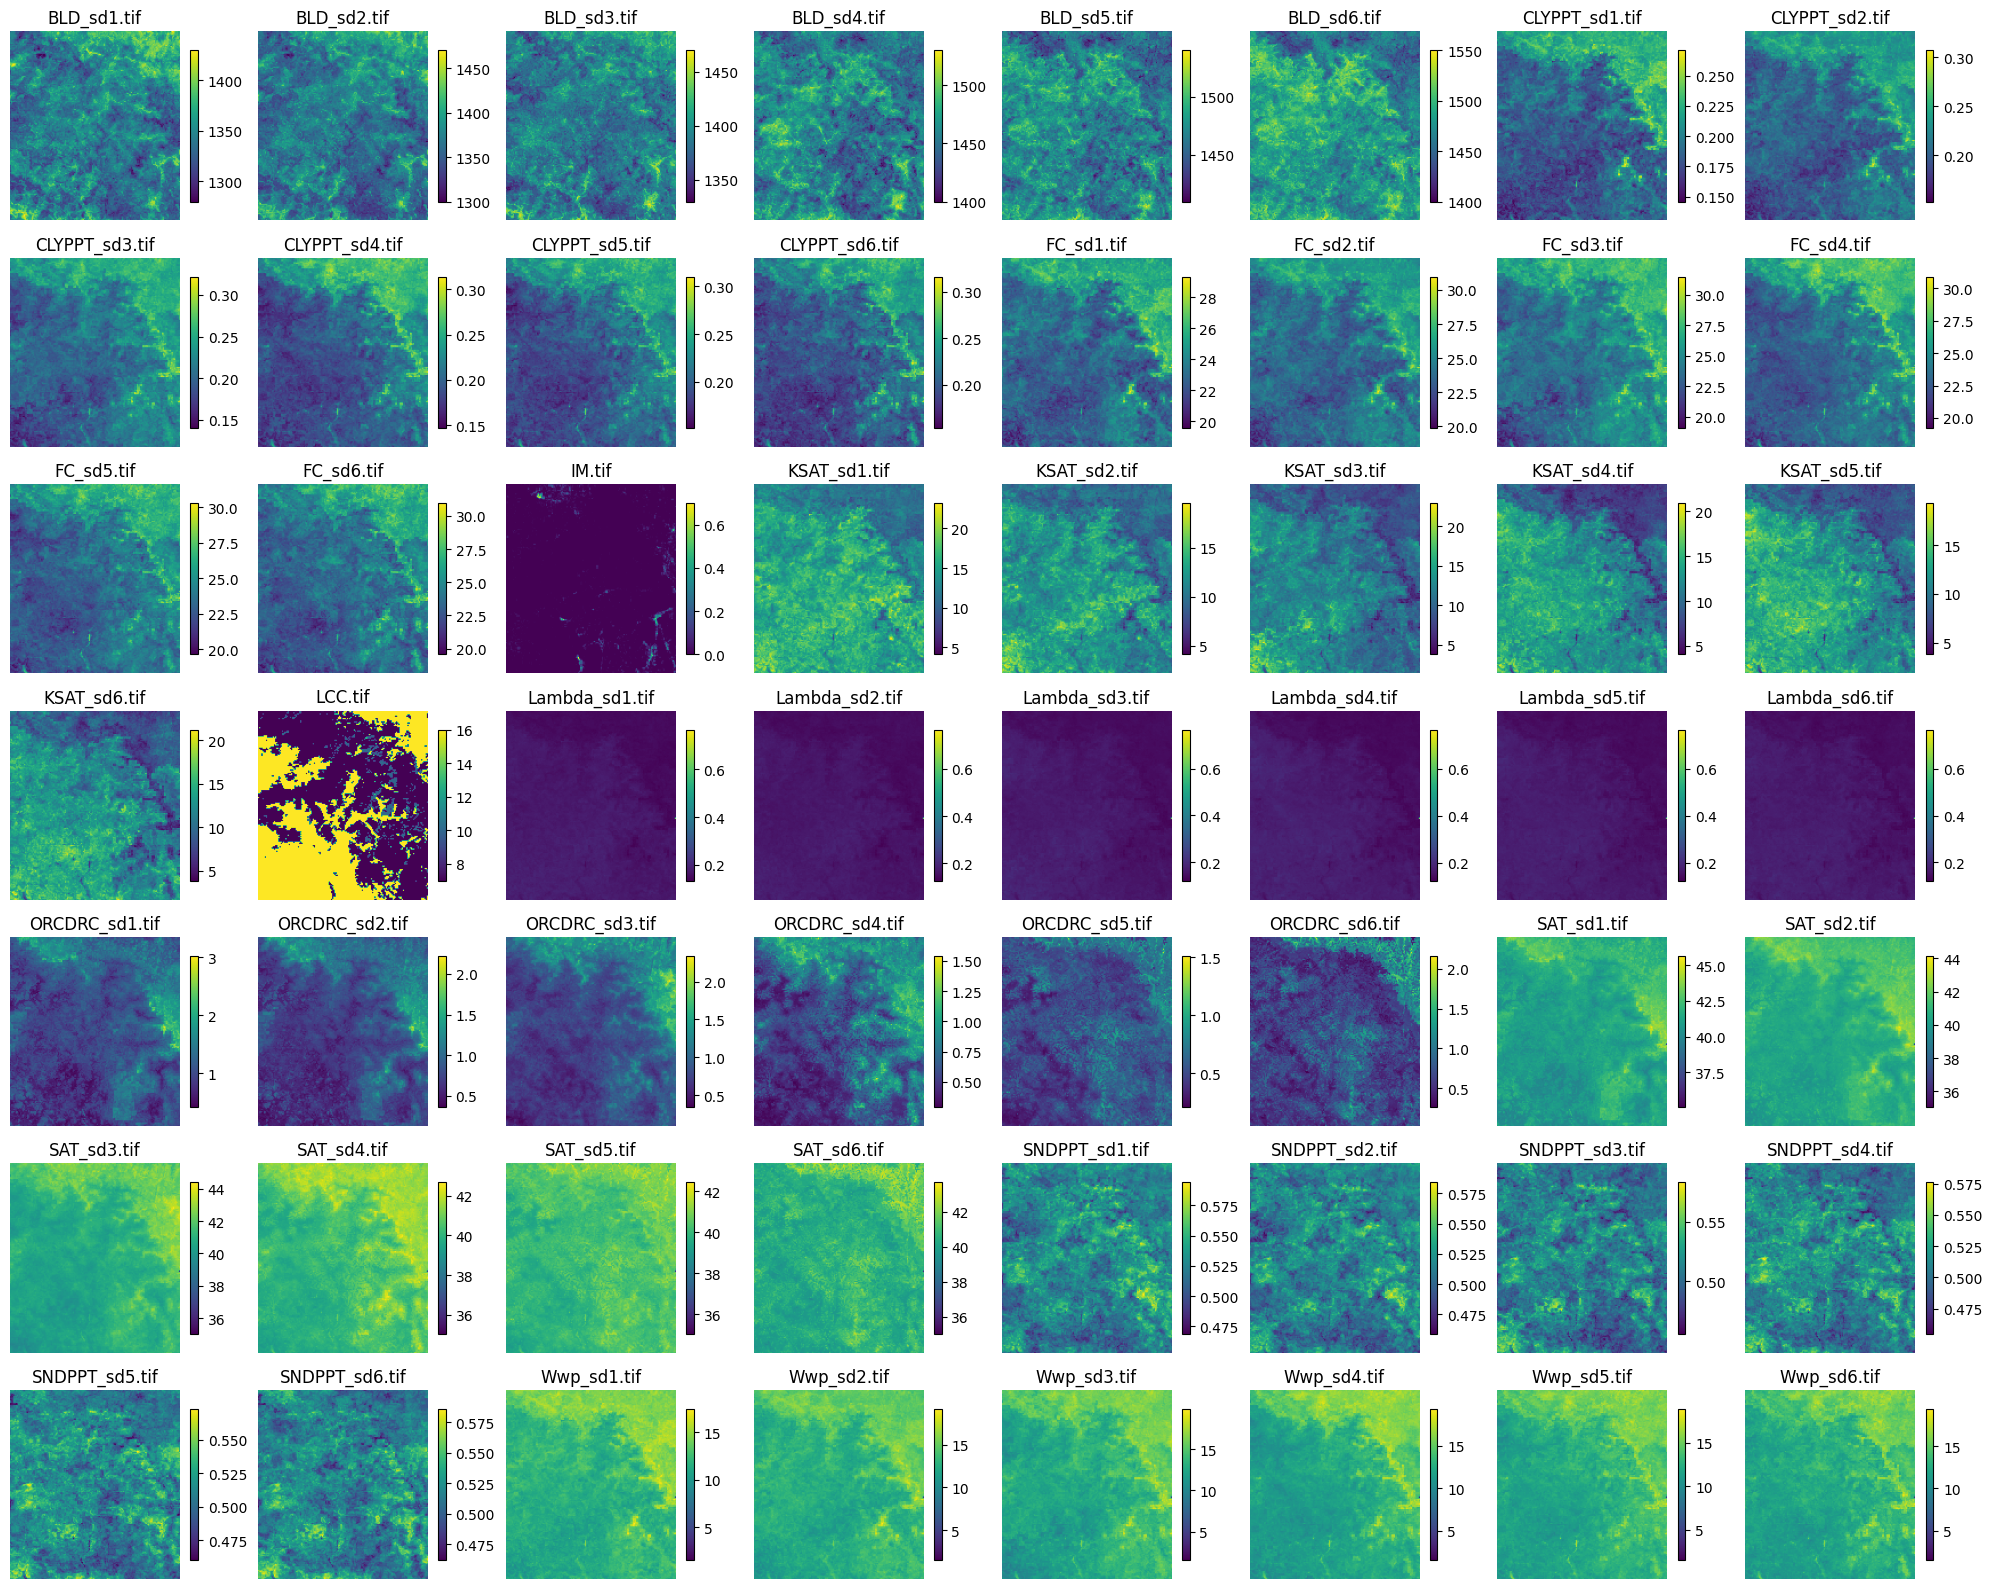

In [48]:
import os
import matplotlib.pyplot as plt
import rasterio
from math import ceil, sqrt

param_output_folder = '/Users/qyang/Downloads/data/CREST/CREST_tutorial/demo_project/param_MidWestCoast'

# Get the list of .tif files in the folder
tif_files = [filename for filename in os.listdir(param_output_folder) if filename.endswith('.tif')]

# Sort the list of files with the string before plot
tif_files.sort()

# Calculate the number of rows and columns for the matrix layout
num_plots = len(tif_files)
num_cols = int(ceil(sqrt(num_plots)))
num_rows = int(ceil(num_plots / num_cols))

# Set the figure size and reduce the interval between subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 16))
plt.subplots_adjust(hspace=0.3, wspace=0.2)  # Adjust the hspace and wspace values as per your preference

# Iterate over the .tif files and plot each raster in a subplot
for i, filename in enumerate(tif_files):
    filepath = os.path.join(param_output_folder, filename)
    
    # Open the .tif file
    with rasterio.open(filepath, 'r+') as dataset:
        raster = dataset.read(1)  # Read the first band (assuming it's a single-band raster)

    # Calculate the subplot position in the matrix
    row = i // num_cols
    col = i % num_cols
    
    # Plot the raster in the corresponding subplot
    ax = axes[row, col] if num_rows > 1 else axes[col]
    img = ax.imshow(raster, cmap='viridis')
    ax.set_title(filename)
    ax.axis('off')
    
    # Add a legend to the subplot
    fig.colorbar(img, ax=ax, orientation='vertical', shrink=0.8)

# Remove any empty subplots
if num_plots < num_rows * num_cols:
    if num_rows > 1:
        for i in range(num_plots, num_rows * num_cols):
            fig.delaxes(axes[i // num_cols, i % num_cols])
    else:
        for i in range(num_plots, num_rows * num_cols):
            fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


## 3 Forcing Data
In this section, we will prepare the forcing data from ERA5-land reanalysis products.

The forcing variables used in CREST are:

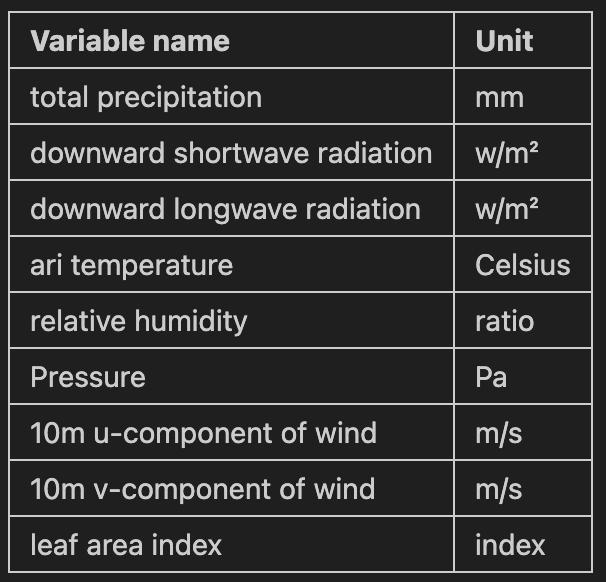

### 3.1 Environment

In [31]:
!pip install cdsapi
!conda install xarray cfgrib -c conda-forge -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.5.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/homebrew/anaconda3/envs/hydro

  added / updated specs:
    - cfgrib
    - xarray


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cfgrib-0.9.10.4            |     pyhd8ed1ab_0          41 KB  conda-forge
    click-8.1.6                |unix_pyh707e725_0          83 KB  conda-forge
    eccodes-2.31.0             |       hfc33491_0         4.2 MB  conda-forge
    findlibs-0.0.5             |     pyhd8ed1ab_0          12 KB  conda-forge
    krb5-1.21.1                |       h92f50d5_0         1.1 MB  conda-forge
    libcurl-8.2.0              |       hc52a3a8_0         339 KB  conda-forge
    libnetcdf-4.9.2            |nompi_h9fa610

### 3.2 Download forcing from ERA5-Land

Data source:
- [Reanalysis ERA5-Land](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=overview)

API key set up:
- [CDS API How-to](https://cds.climate.copernicus.eu/api-how-to)


In [32]:
crop_extent = (39.23, 21.5, 42.00, 19.15)  # Specify the geographic extent in (left, top, right, bottom) format
ERA5_download_file = './demo_project/ERA5_forcing/ERA5_download.grib' # Specify the download file path

import cdsapi
import warnings
# disable warnings
warnings.filterwarnings("ignore")


c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-land',
    {
        'variable': [
            '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature',
            '2m_temperature', 'leaf_area_index_high_vegetation', 'leaf_area_index_low_vegetation',
            'surface_pressure', 'surface_solar_radiation_downwards', 'surface_thermal_radiation_downwards',
            'total_precipitation',
        ],
        'area': [
            crop_extent[1], crop_extent[0], crop_extent[3], crop_extent[2],
        ],
        'format': 'grib',
        'year': '1987',
        'month': '01',
        'day': [
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', 
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
    },
    ERA5_download_file) 

2023-07-21 07:19:31,278 INFO Welcome to the CDS
2023-07-21 07:19:31,279 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2023-07-21 07:19:31,725 INFO Request is queued
2023-07-21 07:19:32,915 INFO Request is running
2023-07-21 07:27:53,597 INFO Request is completed
2023-07-21 07:27:53,599 INFO Downloading https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data6/adaptor.mars.internal-1689949171.8091457-22582-17-f048ffe5-dfd9-4785-8f04-51a1221d57b0.grib to ./demo_project/ERA5_forcing/ERA5_download.grib (3.3M)
2023-07-21 07:27:56,619 INFO Download rate 1.1M/s   


Result(content_length=3453120,content_type=application/x-grib,location=https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data6/adaptor.mars.internal-1689949171.8091457-22582-17-f048ffe5-dfd9-4785-8f04-51a1221d57b0.grib)

### 3.3 ERA5 forcing preprocess

In [33]:
import os
import xarray as xr
import pandas as pd
import rasterio
from rasterio.transform import from_origin
import numpy as np

file = ERA5_download_file
out_dir = './demo_project/ERA5_forcing/' # Specify the forcing files directory
os.makedirs(out_dir, exist_ok=True)

ds = xr.open_dataset(file, engine='cfgrib')
    
# Constants
Rdry = 287.0597
Rvap = 461.5250
a1 = 611.21
a3 = 17.502
a4 = 32.19
T0 = 273.16

# Loop through each time step and forecast step
for time in ds.time.values:
    for idx, step in enumerate(ds.step.values):
        # Select the data for this time step and forecast step
        ds_timestep = ds.sel(time=time, step=step)
        
        # Format the time as a string
        valid_time = pd.to_datetime(time + step)
        valid_time_str = valid_time.strftime('%Y-%m-%d_%H%M%S')
        
        # Compute hourly_tp value
        try:
            if idx > 0:
                previous_step = ds.step.values[idx-1]
                previous_ds_timestep = ds.sel(time=time, step=previous_step)
                previous_hour_tp = previous_ds_timestep['tp'].values
                hourly_tp = ds_timestep['tp'].values - previous_hour_tp
            else:
                hourly_tp = ds_timestep['tp'].values
        except KeyError:
            hourly_tp = ds_timestep['tp'].values
        hourly_tp *= 1000  # Convert meters to millimeters
        hourly_tp = np.clip(hourly_tp, 0, None)  # Set negative values to zero
        
        # Divide ssrd and strd by the number of seconds in each time step
        seconds_in_step = np.timedelta64(step, 's').astype(int)
        hourly_ssrd = ds_timestep['ssrd'].values / seconds_in_step
        hourly_strd = ds_timestep['strd'].values / seconds_in_step
        
        # Compute relative humidity
        dtas = ds_timestep['d2m'].values  # Convert dewpoint temperature to Celsius
        ps = ds_timestep['sp'].values  # Convert surface pressure to hPa
        
        # credit to https://confluence.ecmwf.int/pages/viewpage.action?pageId=171411214
        # Compute saturation water vapor pressure (E)
        E = a1 * np.exp(a3 * (dtas - T0) / (dtas - a4))
        # Compute saturation specific humidity
        relative_humidity = (Rdry / Rvap) * E / (ps - ((1 - Rdry / Rvap) * E))
        
        # Compute surface temperature in Celsius
        surface_temperature = ds_timestep['t2m'].values - 273.16
        
        # Compute total LAI
        lai_hv = ds_timestep['lai_hv'].values
        lai_lv = ds_timestep['lai_lv'].values
        total_lai = lai_hv + lai_lv
        
        # GeoTiff meta data
        # Get the minimum and maximum longitude and latitude values
        lon_min = ds_timestep.longitude.min().values
        lat_min = ds_timestep.latitude.min().values
        lon_max = ds_timestep.longitude.max().values
        lat_max = ds_timestep.latitude.max().values

        # Compute the number of pixels in x and y directions
        width = len(ds_timestep.longitude)
        height = len(ds_timestep.latitude)

        # Create the transform using from_bounds()
        transform = rasterio.transform.from_bounds(lon_min, lat_min, lon_max, lat_max, width, height)

        meta = {
            'driver': 'GTiff',
            'dtype': 'float32',
            'nodata': None,
            'width': len(ds_timestep.longitude),
            'height': len(ds_timestep.latitude),
            'count': len(ds_timestep.data_vars) + 6,  # Add 6 for hourly_tp, hourly_ssrd, hourly_strd, relative_humidity, surface_temperature, and total_lai bands
            'crs': rasterio.crs.CRS.from_string('EPSG:4326'),  # WGS84
            'transform': transform,
            'compress': 'lzw',
        }
        
        # File name for this time step
        file_name = f'ERA5_{valid_time_str}.tif'
        out_file = os.path.join(out_dir, file_name)
        
        # Save the data for this time step as a new GeoTiff file
        with rasterio.open(out_file, 'w', **meta) as dst:
            # Write hourly_tp band
            dst.write(hourly_tp, len(ds_timestep.data_vars) + 1)
            dst.set_band_description(len(ds_timestep.data_vars) + 1, 'hourly_tp')
            
            # Write hourly_ssrd band
            dst.write(hourly_ssrd, len(ds_timestep.data_vars) + 2)
            dst.set_band_description(len(ds_timestep.data_vars) + 2, 'hourly_ssrd')
            
            # Write hourly_strd band
            dst.write(hourly_strd, len(ds_timestep.data_vars) + 3)
            dst.set_band_description(len(ds_timestep.data_vars) + 3, 'hourly_strd')
            
            # Write relative_humidity band
            dst.write(relative_humidity, len(ds_timestep.data_vars) + 4)
            dst.set_band_description(len(ds_timestep.data_vars) + 4, 'relative_humidity')
            
            # Write surface_temperature band
            dst.write(surface_temperature, len(ds_timestep.data_vars) + 5)
            dst.set_band_description(len(ds_timestep.data_vars) + 5, 'surface_temperature')
            
            # Write total_lai band
            dst.write(total_lai, len(ds_timestep.data_vars) + 6)
            dst.set_band_description(len(ds_timestep.data_vars) + 6, 'total_lai')
            
            # Write other bands
            for i, var in enumerate(ds_timestep.data_vars, start=1):
                data = ds_timestep[var].values
                dst.write(data, i)
                dst.set_band_description(i, var)


Ignoring index file './demo_project/ERA5_forcing/ERA5_download.grib.923a8.idx' older than GRIB file


### 3.4 Forcing statistics
Show the statistics of input forcing data

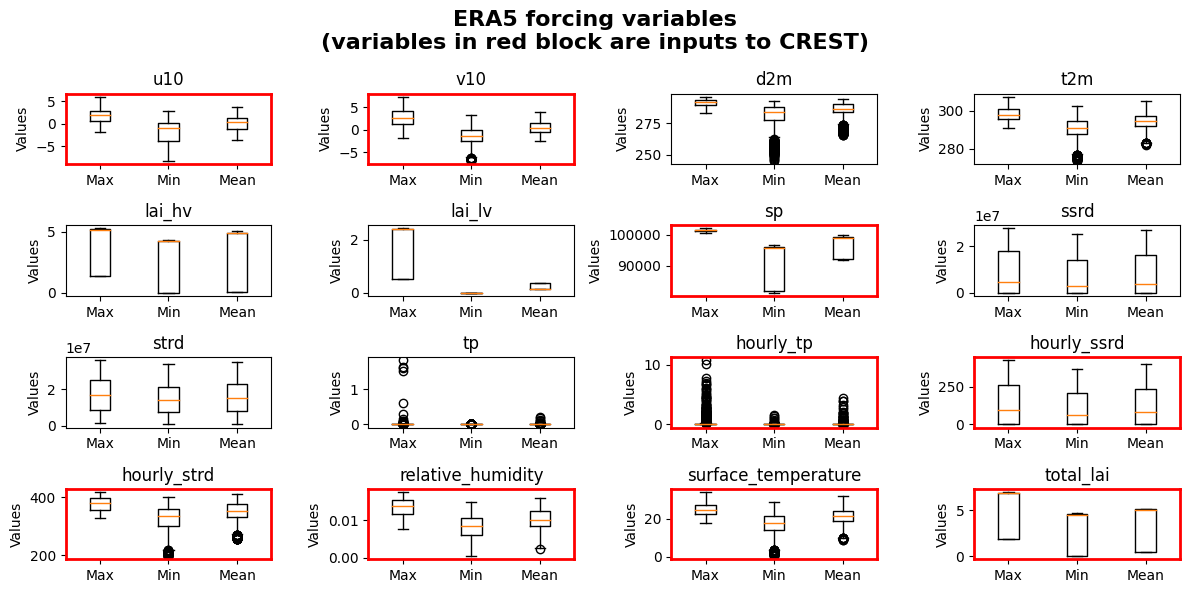

In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio

# specify the directory if want to save elsewhere
out_dir = out_dir
# variables that will be used by CREST
highlighted_bands = ['hourly_ssrd', 'hourly_strd', 'hourly_tp', 'relative_humidity', 'sp', 'surface_temperature', 'total_lai', 'u10', 'v10']

band_dataframes = {}
for filename in os.listdir(out_dir):
    if filename.endswith(".tif"):
        filepath = os.path.join(out_dir, filename)
        
        # Open the .tif file
        with rasterio.open(filepath) as dataset:
            for band in range(1, dataset.count + 1):
                # Read the band data
                data = dataset.read(band)
                
                # Compute statistics
                nanmax = np.nanmax(data)
                nanmin = np.nanmin(data)
                nanmean = np.nanmean(data)
                
                # Get the band name
                band_name = dataset.descriptions[band-1]
                
                # Create a dataframe for the band if it doesn't exist
                if band_name not in band_dataframes:
                    band_dataframes[band_name] = pd.DataFrame(columns=['Filename', 'Band', 'Max', 'Min', 'Mean'])
                
                # Add the band statistics to the dataframe
                band_dataframes[band_name] = pd.concat([
                    band_dataframes[band_name],
                    pd.DataFrame({'Filename': [filename], 'Band': [band], 'Max': [nanmax], 'Min': [nanmin], 'Mean': [nanmean]})
                ])

# Calculate the number of rows and columns for the matrix layout
num_plots = len(band_dataframes)
num_cols = int(np.ceil(np.sqrt(num_plots)))
num_rows = int(np.ceil(num_plots / num_cols))

# Plot boxplot figures in a matrix layout
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

for i, (band_name, df) in enumerate(band_dataframes.items()):
    # Drop NaN values for each column
    df_cleaned = df.dropna()
    
    # Calculate the subplot position in the matrix
    row = i // num_cols
    col = i % num_cols
    
    # Create a boxplot for the band in the corresponding subplot
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.boxplot([df_cleaned['Max'], df_cleaned['Min'], df_cleaned['Mean']], labels=['Max', 'Min', 'Mean'])
    ax.set_title(band_name)
    ax.set_ylabel('Values')
    
    # Check if the current band should be highlighted
    if band_name in highlighted_bands:
        # Add a red border around the subplot
        ax.spines['top'].set_color('red')
        ax.spines['bottom'].set_color('red')
        ax.spines['left'].set_color('red')
        ax.spines['right'].set_color('red')
        ax.spines['top'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        ax.spines['right'].set_linewidth(2)
    
# Remove any empty subplots
if num_plots < num_rows * num_cols:
    if num_rows > 1:
        for i in range(num_plots, num_rows * num_cols):
            fig.delaxes(axes[i // num_cols, i % num_cols])
    else:
        for i in range(num_plots, num_rows * num_cols):
            fig.delaxes(axes[i])

# Add a title to the figure
fig.suptitle('ERA5 forcing variables\n(variables in red block are inputs to CREST)', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()
